# TUTORIAL 1: Coordinates, Distributors, and Bases

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

[LAPTOP-TL1238BG:02678] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.LAPTOP-TL1238BG.1000/jf.0/4142792704/shared_mem_cuda_pool.LAPTOP-TL1238BG could be created.
[LAPTOP-TL1238BG:02678] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1.1 - Coordinate Systems

A coordinate system must be used. We can use 4 types of coordinate systems. 1D coordinate systems can be defined using the Coordinate class.
However to use higher dimensional coordinates we need to use the class CoordinateSystem

In [4]:
#Cartesian coordinate system can be constructed such as:
coords = d3.CartesianCoordinates('x', 'y', 'z')

## 1.2 - Distributors

To build a distributor, we need to pass the coord system of our PDE, specify the datatype of the fields we use, and optionally specify a process mesh for parallelization

In [5]:
dist = d3.Distributor(coords, dtype=np.float64) #Don't need a mesh for serial/auto parallelization

### Parallelizations & process meshes

When running in an MPI environment, Dedalus uses block-distributed domain decompositions to parallelize computations.Arbitrary mesh processes can be selected using the mesh command in the line of code above. The current MPI environment MUST have the same amount of processes as the product of the mesh shape.

The mesh dimension MUST be less than or equal to the number of separable coordinates in the linear part of the PDE. This typically means that the problem can be parallelized over any periodic and angular coords. However, for fully separable problems, the mesh dimension MUST be less than the total dimension.

### Layouts

In [6]:
for layout in dist.layouts:
    print('Layout {}:  Grid space: {}  Local: {}'.format(layout.index, layout.grid_space, layout.local))

Layout 0:  Grid space: [False False False]  Local: [ True  True  True]
Layout 1:  Grid space: [False False  True]  Local: [ True  True  True]
Layout 2:  Grid space: [False  True  True]  Local: [ True  True  True]
Layout 3:  Grid space: [ True  True  True]  Local: [ True  True  True]


In [7]:
# Don't do this. For illustration only.
dist.mesh = np.array([4, 2])
dist.comm_coords = np.array([0, 0])
dist._build_layouts(dry_run=True)

In [8]:
for layout in dist.layouts:
    print('Layout {}:  Grid space: {}  Local: {}'.format(layout.index, layout.grid_space, layout.local))

Layout 0:  Grid space: [False False False]  Local: [False False  True]
Layout 1:  Grid space: [False False  True]  Local: [False False  True]
Layout 2:  Grid space: [False False  True]  Local: [False  True False]
Layout 3:  Grid space: [False  True  True]  Local: [False  True False]
Layout 4:  Grid space: [False  True  True]  Local: [ True False False]
Layout 5:  Grid space: [ True  True  True]  Local: [ True False False]


## 1.3 - Bases

### Creating a basis

Each basis class defines spectral operators and the transformers between grid space and coefficient space representations in that basis. Most commonly used basis types:

- RealFourier: Used for real periodic functions on an interval using cosine and sine modes
- ComplexFourier: For complex periodic functions on an interval using complex exponentials
- Cheyshev: For functions on an interval
- Jacobi: For functions on an interval under a more general inner product (Usually Chebyshev is better for performance)
- DiskBasis: For functions on a full disk in polar coordinates 
- AnnulusBasis: For functions on an annulus in polar coordinates 
- SphereBasis: For functions on a full ball in spherical coordinates
- ShellBasis: For functions on a spherical shell in spherical coordinates

In [9]:
xbasis = d3.RealFourier(coords['x'], size=32, bounds=(0,1), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=32, bounds=(0,1), dealias=3/2)
zbasis = d3.Chebyshev(coords['z'], size=32, bounds=(0,1), dealias=3/2)

### Basis grids and scale factors

Each basis has a corresponding coordinate/collocation grid (or grids for multiple bases) that can be used for tasks like plotting or initializing fields. The global (non-distributed) grids of a basis can be accessed using the basis object's global_grid method (or global_grids for multidimensional bases). These methods optionally take scale factors determining the number of points in the grid relative to the number of basis models. 

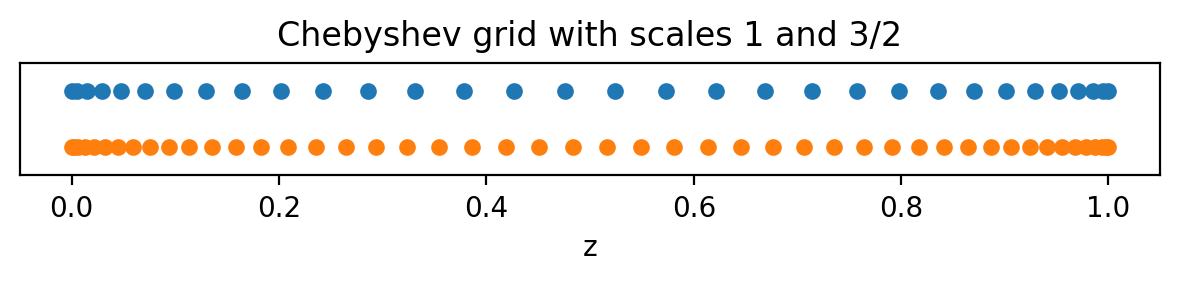

In [10]:
grid_normal = zbasis.global_grid(dist, scale=1).ravel()
grid_dealias = zbasis.global_grid(dist, scale=3/2).ravel()

plt.figure(figsize=(6, 1.5), dpi=100)
plt.plot(grid_normal, 0*grid_normal+1, 'o', markersize=5)
plt.plot(grid_dealias, 0*grid_dealias-1, 'o', markersize=5)
plt.xlabel('z')
plt.title('Chebyshev grid with scales 1 and 3/2')
plt.ylim([-2, 2])
plt.gca().yaxis.set_ticks([]);
plt.tight_layout()

### Distributed grid and element arrays 

To help with creating field data, the distributor provides the local portions of the coordinate grids and mode numbers (wavenumbers or polynomial degrees). The local grids (distributed according to the last layout, or full "grid space") are accessed using the dist.local_grid (or dist.local_grids for multidimensional bases) method and specifying the basis and factors.

In [11]:
local_x = dist.local_grid(xbasis)
local_y = dist.local_grid(ybasis)
local_z = dist.local_grid(zbasis)
print('Local x shape:', local_x.shape)
print('Local y shape:', local_y.shape)
print('Local z shape:', local_z.shape)

Local x shape: (32, 1, 1)
Local y shape: (1, 8, 1)
Local z shape: (1, 1, 16)


In [12]:
local_kx = dist.local_modes(xbasis)
local_ky = dist.local_modes(ybasis)
local_nz = dist.local_modes(zbasis)
print('Local kx shape:', local_kx.shape)
print('Local ky shape:', local_ky.shape)
print('Local nz shape:', local_nz.shape)

Local kx shape: (8, 1, 1)
Local ky shape: (1, 16, 1)
Local nz shape: (1, 1, 32)


# TUTORIAL 2: Fields and Operators

Focuses on the basics of setting up and interacting with field and operator objects in Dedalus.

In [13]:
from dedalus.extras.plot_tools import plot_bot_2d
figkw = {'figsize':(6,4), 'dpi':100}

## 2.1 - Fields

### Creating a field

Field objects in Dedalus represent scalar-valued fields defined over a set of bases. A field can be directly instantiated from the Field class by passing a distributor, a list of bases, and a name. Also can be instantiated using the dist.Field method.

In [14]:
#Setting up a 2D domain and building a field:

coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=np.float64)

xbasis = d3.RealFourier(coords['x'], 64, bounds=(-np.pi, np.pi), dealias=3/2)
ybasis = d3.Chebyshev(coords['y'], 64, bounds=(-1, 1), dealias=3/2)

f = dist.Field(name='f', bases=(xbasis, ybasis))

This field 'f', is a function of both x and y, since it is defined by using both the x and y bases. If we wanted a function that only relied on x or y, we could just set the bases to bases=xbasis or bases=ybasis

### Vector and tensor fields

Vector fields can be created using the VectorField constructor and by passing the coord system corresponding to the components you want the vector to have. Similarly, tensor fields can be constructed using TensorField, and then by passing a tuple of coord systems.

In [15]:
u = dist.VectorField(coords, name='u', bases=xbasis)

### Manipulating field data

The layout attribute of each field points to the layout object describing it's current transform and distribution state

In [16]:
f.layout.grid_space

array([False, False])

Field data can be assigned and retrieved in any layout by indexing a field with that layout object. In most cases, mixed layouts are not needed, and it's just the full grid and the full coefficient data are most useful to interact with. (They can be accessed using the 'g' or 'c' shortcuts)

When accessing field data in parallel, each process manipulates just the local data of the globally distributed dataset. We therefore can set a field's grid data in a parallel-safe fashion byusing the local grids provided by the domain object:

(<Axes: xlabel='x', ylabel='y'>, <Axes: xlabel="f['g']">)

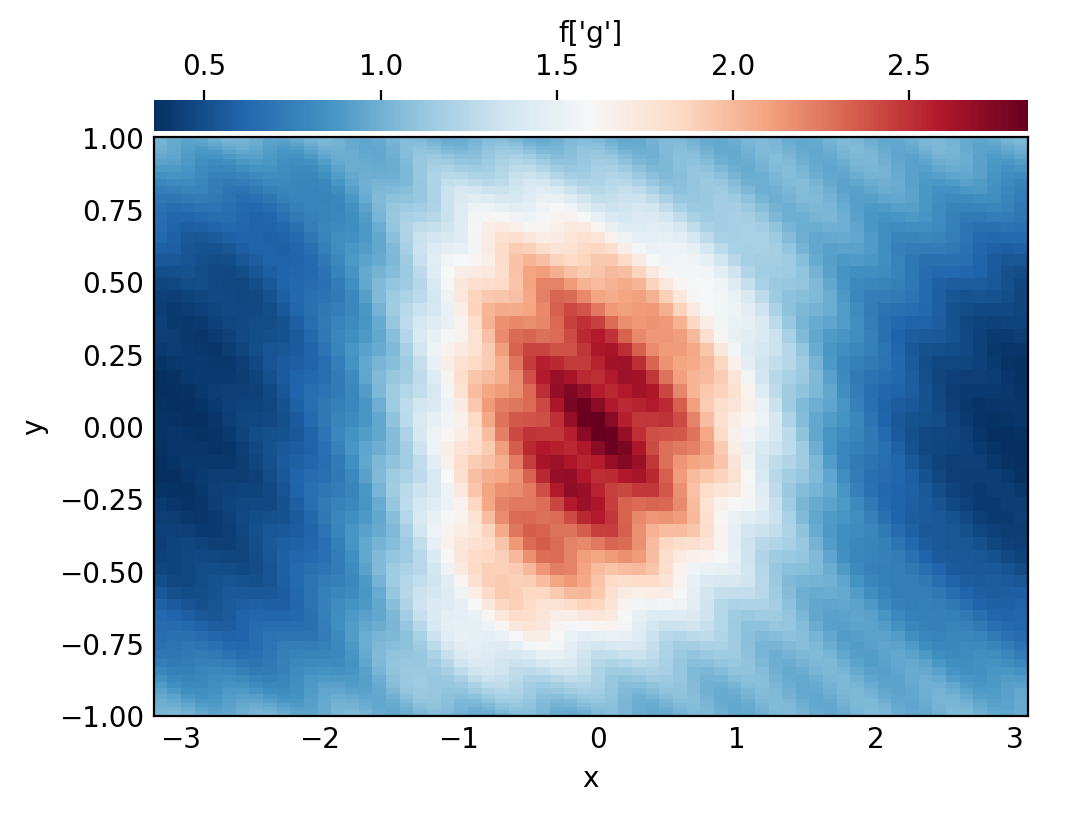

In [17]:
x = dist.local_grid(xbasis)
y = dist.local_grid(ybasis)
f['g'] = np.exp((1-y**2)*np.cos(x+np.cos(x)*y**2)) * (1 + 0.05*np.cos(10*(x+2*y)))

# Plot grid values
plot_bot_2d(f, figkw=figkw, title="f['g']")

We can convert a field to it's spectral coefficients by requesting the field's data in coefficient space.

/tmp/ipykernel_2678/1812536267.py:4: RuntimeWarning: divide by zero encountered in log10
  log_mag = lambda xmesh, ymesh, data: (xmesh, ymesh, np.log10(np.abs(data)))


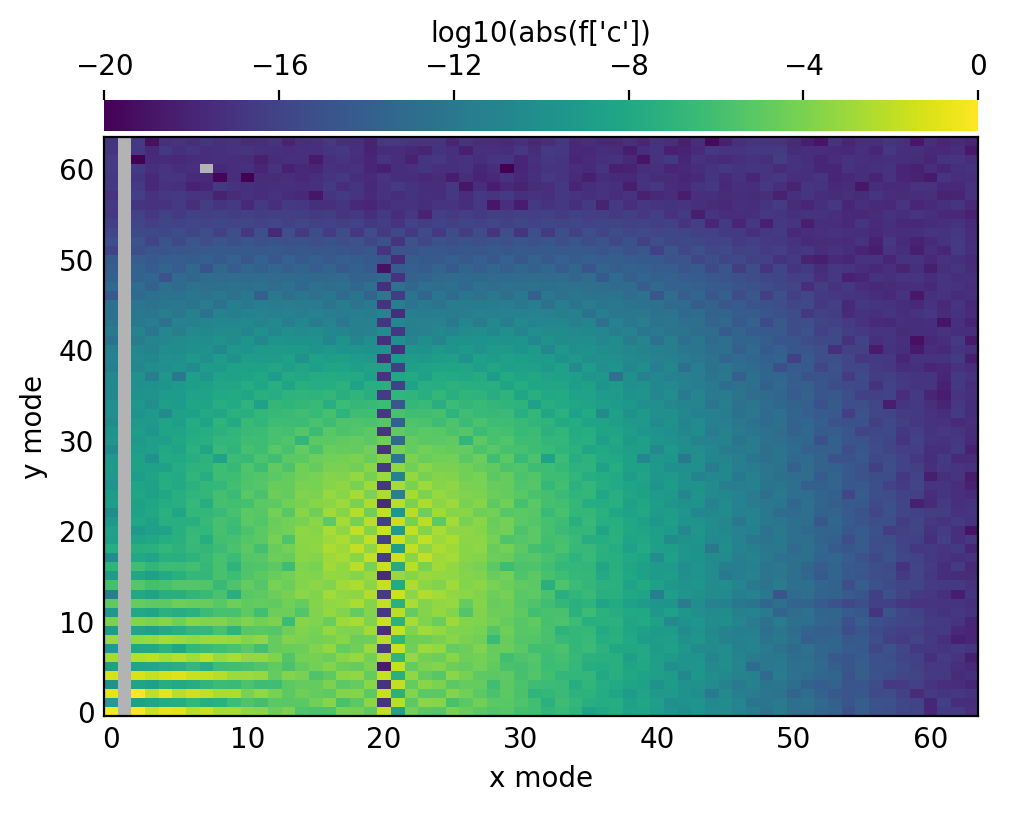

In [18]:
f['c']

# Plot log magnitude of spectral coefficients
log_mag = lambda xmesh, ymesh, data: (xmesh, ymesh, np.log10(np.abs(data)))
plot_bot_2d(f, func=log_mag, clim=(-20, 0), cmap='viridis', title="log10(abs(f['c'])", figkw=figkw);

### Vector and tensor components

In [19]:
u['g'].shape

(2, 64, 1)

First axis size is 2, which corresponds to our two vector components of x and y. The (64,1) represents the x and y axis, y axis is only 1 as it is constant here. (We only used the xbasis)

### Field scale factors

The change_scale method on a field lets us change the scaling factor used when transforming the field's data in grid space. Shape errors may arise if there's a mismatch between the field and the grid's scale factor.

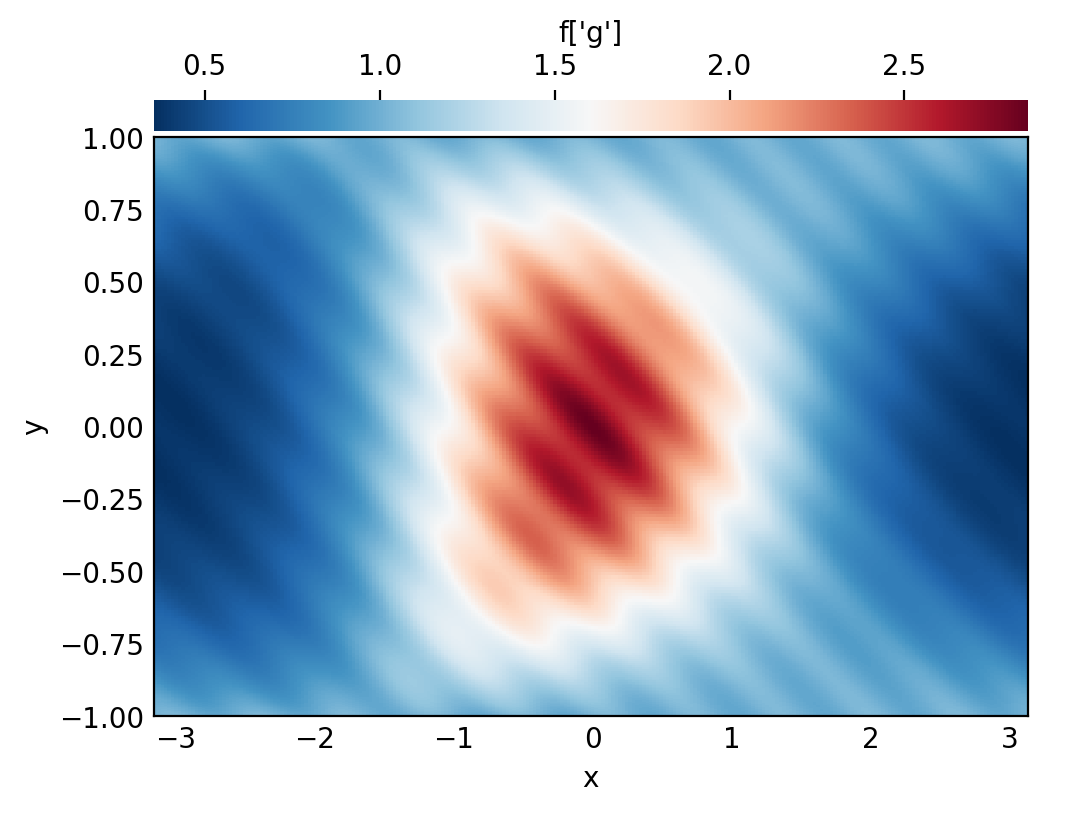

In [20]:
f.change_scales(4)

# Plot grid values
f['g']
plot_bot_2d(f, title="f['g']", figkw=figkw);

## 2.2 - Operators

## Arithmetic with fields

Mathematical operations on fields, including arithmetic, differentiation, integration, and interpolation, are represented by Operator classes.

In [21]:
g_op = 1 - 2*f
print(g_op)

C(C(1)) + -1*2*f


The object we get is not another field, but an operator object representing the addition of 1 to the multiplication of -1, 2, and our field. To compute this operation, use the evaluate method, which returns the new field as the result.

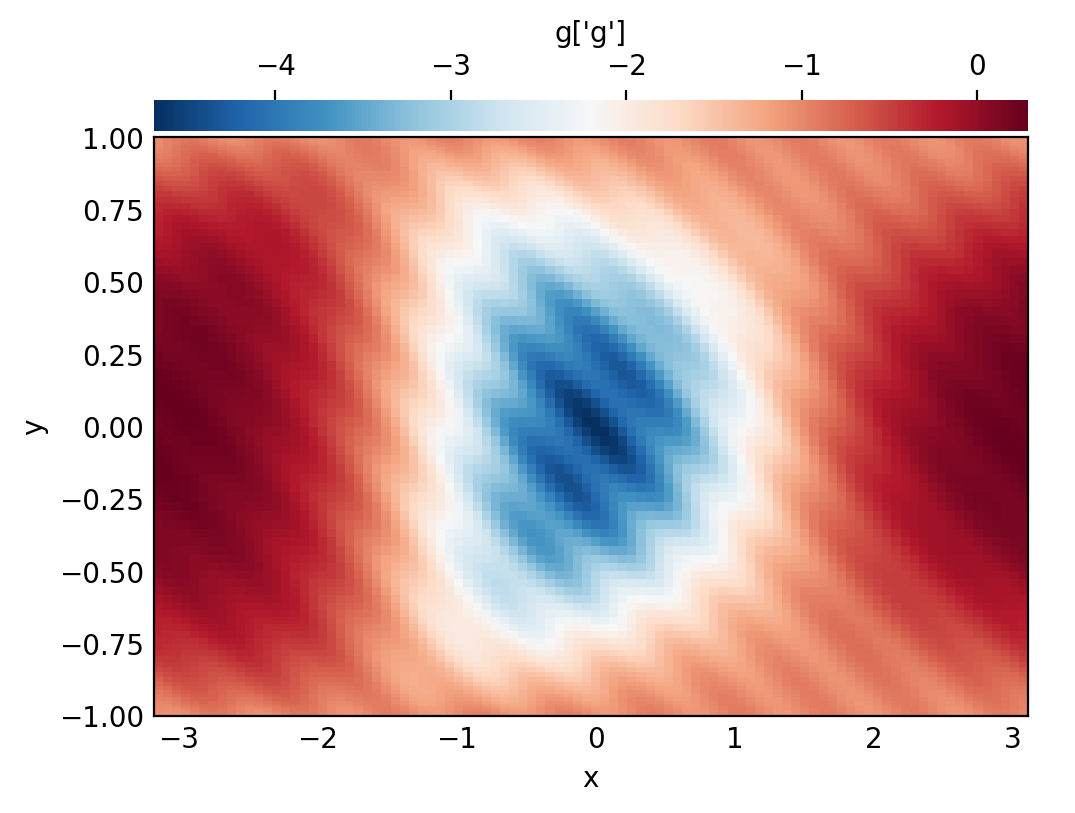

In [22]:
g = g_op.evaluate()

# Plot grid values
g['g']
plot_bot_2d(g, title="g['g']", figkw=figkw);

## Building expressions 

Operator instances can be passed as arguments to other operators, building trees that represent more complicated expressions:

In [23]:
h_op = 1 / np.cosh(g_op + 2.5)
print(h_op)

Pow(cosh(C(C(1)) + -1*2*f + C(C(2.5))), -1)


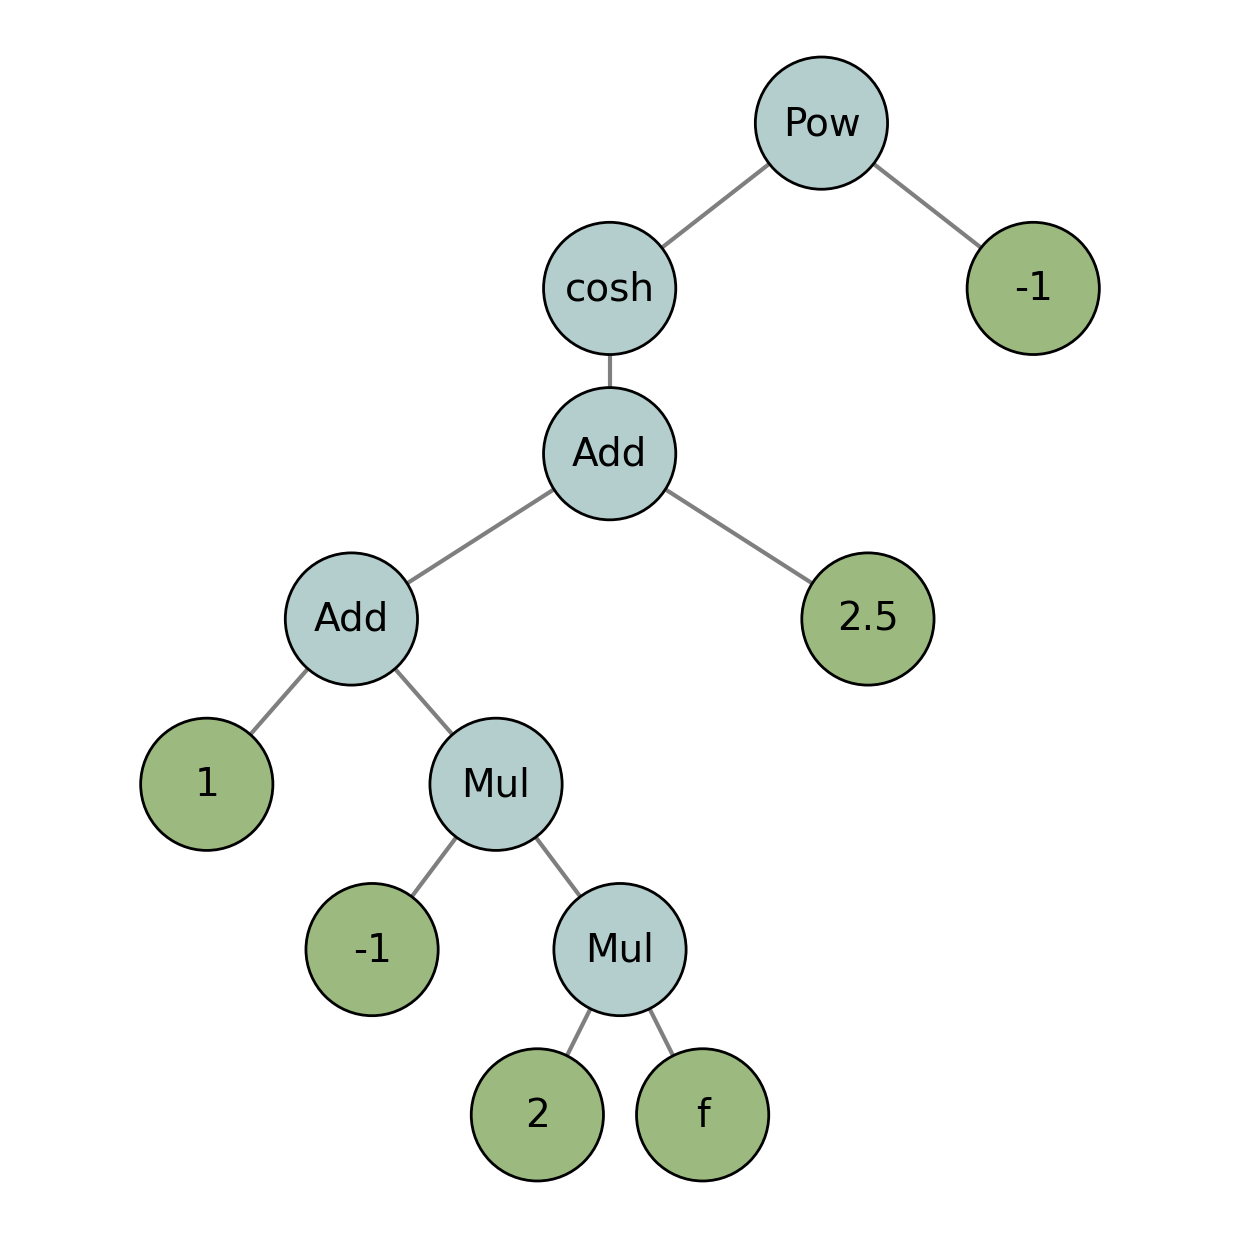

In [24]:
#We can plot this using a tool from dedalus:

from dedalus.tools.plot_op import plot_operator
plot_operator(h_op, figsize=6, fontsize=14, opsize=0.4)

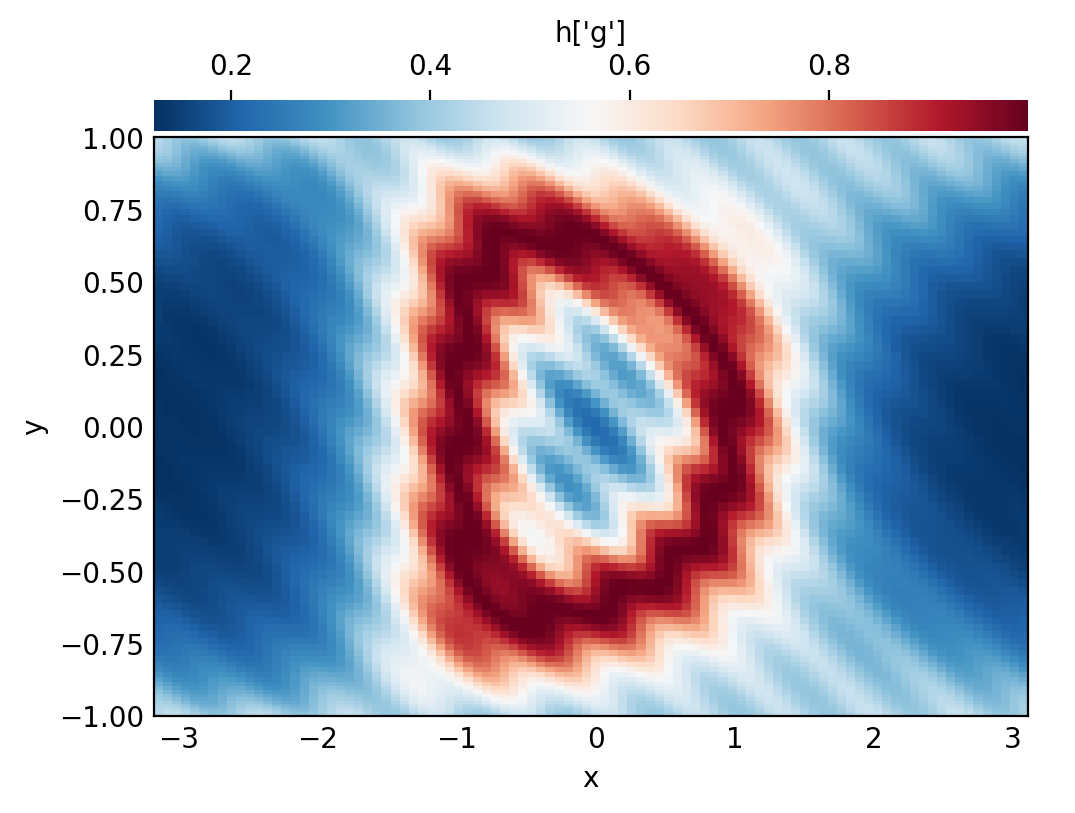

In [25]:
#Evaluating it:

h = h_op.evaluate()

# Plot grid values
h['g']
plot_bot_2d(h, title="h['g']", figkw=figkw);

## Deferred evaluation

A key point is that the operator objects symbolically represent an operation on the field arguments, and are evaluated using deferred evaluation. If we change the data of the field arguments and re-evaluate an operator, we get a new result.

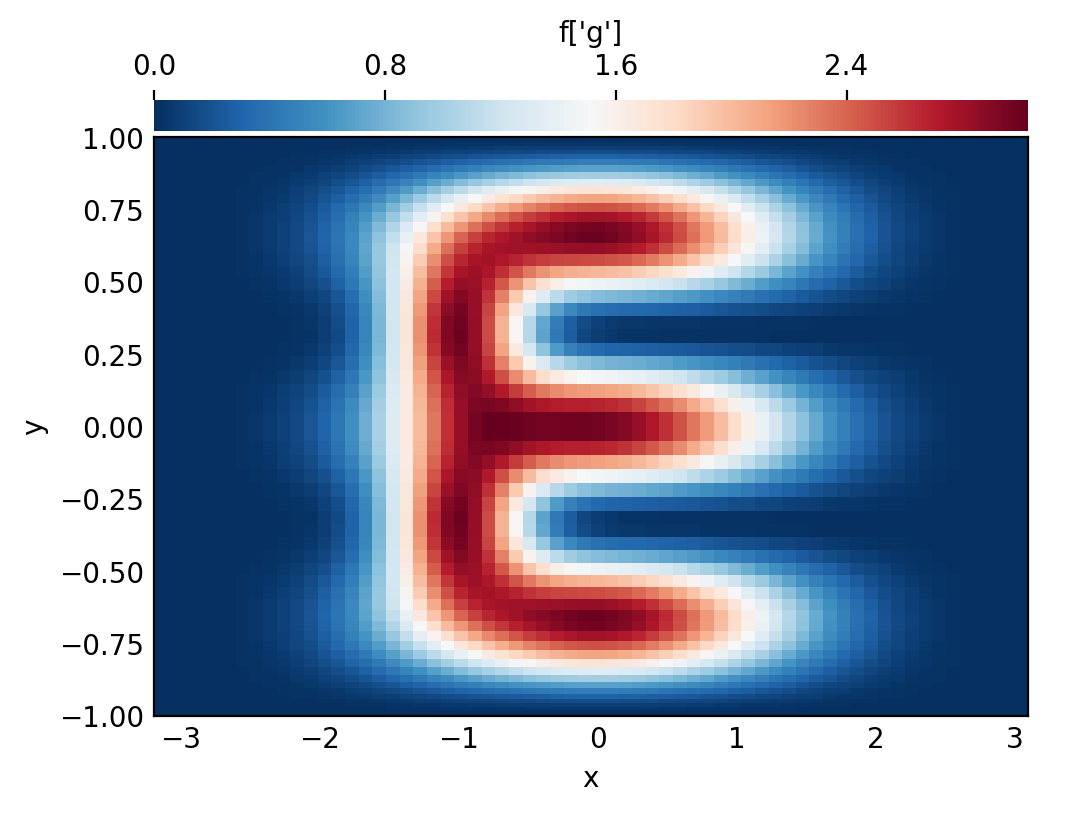

In [26]:
# Change scales back to 1 to build new grid data
f.change_scales(1)
f['g'] = 3*np.cos(1.5*np.pi*y)**2 * np.cos(x/2)**4 + 3*np.exp(-((2*x+2)**2 + (4*y+4/3)**2)) + 3*np.exp(-((2*x+2)**2 + (4*y-4/3)**2))

# Plot grid values
f['g']
plot_bot_2d(f, title="f['g']", figkw=figkw);

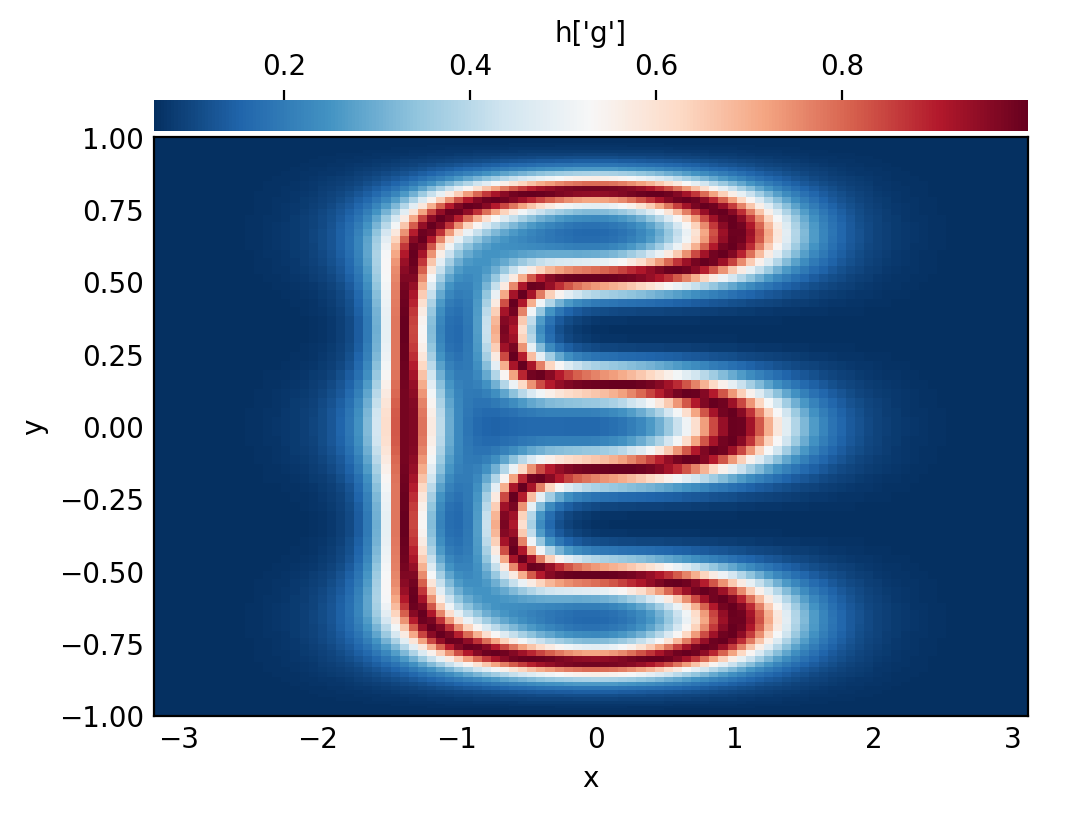

In [27]:
h = h_op.evaluate()

# Plot grid values
h['g']
plot_bot_2d(h, title="h['g']", figkw=figkw);

## Differential operators

Operators are also used for differentiation fields. PD operators are implemented for 1D bases by using the Differentiate operator and specifying the coordinates used for differentiating.

In [28]:
fx = d3.Differentiate(f, coords['x'])

For multidimensional problems it's more common to use the built in vector calculus operators:

- Gradient: For arbitrary fields
- Divergence: For arbitrary vector/tensor fields
- Curl: For vector fields
- Laplacian: Defined as the divergence of the gradient, for arbitrary fields

A coordinate system can optionally be specified as the tangent bundle for the gradient and Laplacian, and a tensor index can optionally be specified for the divergence. The gradiant of a rank r tensor field will be a r+1 tensor field. 

In [29]:
lap_f = d3.Laplacian(f).evaluate()
grad_f = d3.Gradient(f).evaluate()
print('f shape:', f['g'].shape)
print('Grad(f):', grad_f['g'].shape)
print('Lap(f):', lap_f['g'].shape)

div_grad_f = d3.Divergence(grad_f).evaluate()
print('Lap(f) is Div(Grad(f)):', np.allclose(lap_f['g'], div_grad_f['g']))

f shape: (96, 96)
Grad(f): (2, 96, 96)
Lap(f): (96, 96)
Lap(f) is Div(Grad(f)): True


## Tensor operators

Several operators are defined for manipulating the components of tensor fields, including:

- Trace: For contracting two specified indices
- TransposeComponents: For swapping two specified indices
- Skew: For taking a positive 90 degree rotation of 2D vector fields

In [30]:
grad_u = d3.Gradient(u)
transpose_grad_u = d3.TransposeComponents(grad_u)

## Integrals and averages

Integrals and averages of scalar fields over coordinates / coordinate systems are computed with the Integrate and Average operators.

In [31]:
#Total integral of the field

f_int = d3.Integrate(f, ('x', 'y'))
print('Integral of f:', f_int.evaluate()['g'])

#Avg of the field

f_avg = d3.Average(f, ('x', 'y'))
print('Average of f:', f_avg.evaluate()['g'])

Integral of f: [[9.42458659]]
Average of f: [[0.74998477]]


## Interpolation

Interpolation along a coordinate is computed with the Interpolate operator, or using the __call__ method on fields/operators, with keywords specifying the coordinate and position. The strings 'left', 'right', and 'center' can be used to refer to the endpoints and middle of 1D intervals, respectively, for convenience.

In [32]:
f00 = f(x=0, y=0)
print('f(0,0):', f00.evaluate()['g'])

f(0,0): [[3.01857352]]


# TUTORIAL 3: Problems and Solvers

## 3.1 - Problems

### Problem initializations

To create a problem object, a list of field variables to be solved must be provided. A dictionary can be passed through the namespace argument during problem instantiation to make substitutions available when parsing the equations later on. Typically we suggest passing locals() here, to make all script-level definitions available inside the problem.

Set up a complex Ginzburg-Landau equation (CGLE) for a variable u(x,t) on a finite interval x = [0, 300]

Discretize x with a Chebyshev basis and pick dealiasing factor of 2.

This version of Dedalus needs us to use Tau as unknowns to the problem in order to enforce the boundary conditions. The problem here requires two Tau terms.

In [43]:
#Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=np.complex128)
xbasis = d3.Chebyshev(xcoord, 1024, bounds=(0, 300), dealias=2)

#Fields
u = dist.Field(name='u', bases=xbasis)
tau1 = dist.Field(name='Tau1')
tau2 = dist.Field(name='Tau2')

#Problem
problem = d3.IVP([u, tau1, tau2], namespace=locals())

### Substitutions

A little more about substitutions, or using non-variable objects inside the problem. These can include other fields that define e.g. the forcing or non-constant coefficients (NCCs) of the PDE. NCCs appearing on the LHS will couple the dimensions that they have bases for, so it’s important to only use bases for the non-constant dimensions when creating an NCC field.

There are no periodic dimensions or NCC. But for the sake of showing the process: Suppose we have a 3D problem on a Fourier (x) SinCos (y) and Chebyshev (z), here's how to add a non-constant coefficient in z to the problem:

In [44]:
#ncc = dist.Field(bases=zbasis)
#ncc['g'] = z**2

Substitutions can also include aliases to operators computed from the problem variables or helper functions that streamline the equation entry. Here we will use simple substitutions for calling the Differentiate operator, for computing the square magnitude of u, defining the a and b parameters in the PDE, and defining the tau polynomials.

In [45]:
#Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
magsq_u = u * np.conj(u)
b = 0.5
c = -1.76

#Tau polynomials
tau_basis = xbasis.derivative_basis(2)
p1 = dist.Field(bases=tau_basis)
p2 = dist.Field(bases=tau_basis)
p1['c'][-1] = 1
p2['c'][-2] = 2

### Equation Entry

Equations can then be entered as pairs of operator expressions like (LHS, RHS) or as strings like "LHS = RHS". In addition the subtitutions made available via the provided namespace, the string parsing recognises all the built-in operators as well as the abbreviations for them.

Enter the CGLE and the boundary conditions:

In [46]:
#Add main equation with linear terms on the LHS and the non-linear terms of the RHS
problem.add_equation("dt(u) - u - (1 + 1j*b)*(dx(dx(u))) + tau1*p1 + tau2*p2 = - (1 + 1j*c) * magsq_u * u")

#Add boundary conditions
problem.add_equation("u(x='left') = 0")
problem.add_equation("u(x='right') = 0")

{'eqn': interp(<Field 140341727297456>, x=right),
 'LHS': interp(<Field 140341727297456>, x=right),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'valid_modes': array([ True]),
 'M': 0,
 'L': interp(<Field 140341727297456>, x=right),
 'F': <Field 140341733011392>,
 'domain': <dedalus.core.domain.Domain at 0x7fa3db24b230>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

## 3.2 - Solvers

Each problem type (IVP, EVP, LBVP, NLBVP) has a corresponding solver class that actually performs the solution steps for the correpsonding problem. Solvers are built using the problem.build_solver method.

For IVPs, we select a timestepping method when building the solver. Several multistep and Runge-Kutta IMEX  schemes are available and can be selected by name.

In [47]:
# Build solver
solver = problem.build_solver(d3.RK222)

2025-05-28 15:45:27,378 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s


### Set stopping criteria

For IVPs, stopping criteria for halting time evolution are specified by setting the solver.stop_iteration, solver.stop_wall_time and/or solver.stop_sim_time attributes.

Let's stop at t = 500 in simulation units:

In [48]:
#Stopping criteria
solver.stop_sim_time = 500

### Setting initial conditions

For IVPs and non-linear BVPs, the initial conditions are set by directly modifying the state variable data before the simulation.

In [49]:
#Setup a sine wave
x = dist.local_grid(xbasis)
u['g'] = 1e-3 * np.sin(5 * np.pi * x / 300)

### Solving/iterating a problem

IVPs are iterated using the solve.step method with a provided timestep. EVPs are solved using the solver.solve_dense or solver.solve_sparse methods. LBVPs are solved using the solver.solve method. NLBVPs are iterated using the solver.newton_iteration method.

The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script. The solver.process property will change from True to False once any of the specified stopping criteria have been met. Let's timestep our problem until the halting condition has been met, copying the grid values of u every few iterations.

In [50]:
#Setup storage
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]

#Main loop
timestep = 0.05
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 10 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

    if solver.iteration % 1000 == 0:
        print('Completed interation {}'.format(solver.iteration))

#Convert storage list to arrays
u_array = np.array(u_list)
t_array = np.array(t_list)

Completed interation 1000
Completed interation 2000
Completed interation 3000
Completed interation 4000
Completed interation 5000
Completed interation 6000
Completed interation 7000
Completed interation 8000
Completed interation 9000
Completed interation 10000
2025-05-28 16:02:02,225 solvers 0/1 INFO :: Simulation stop time reached.


/tmp/ipykernel_2678/1382269126.py:3: UserWarning: shading value 'farthest' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(x, t_array, np.abs(u_array), shading='farthest')


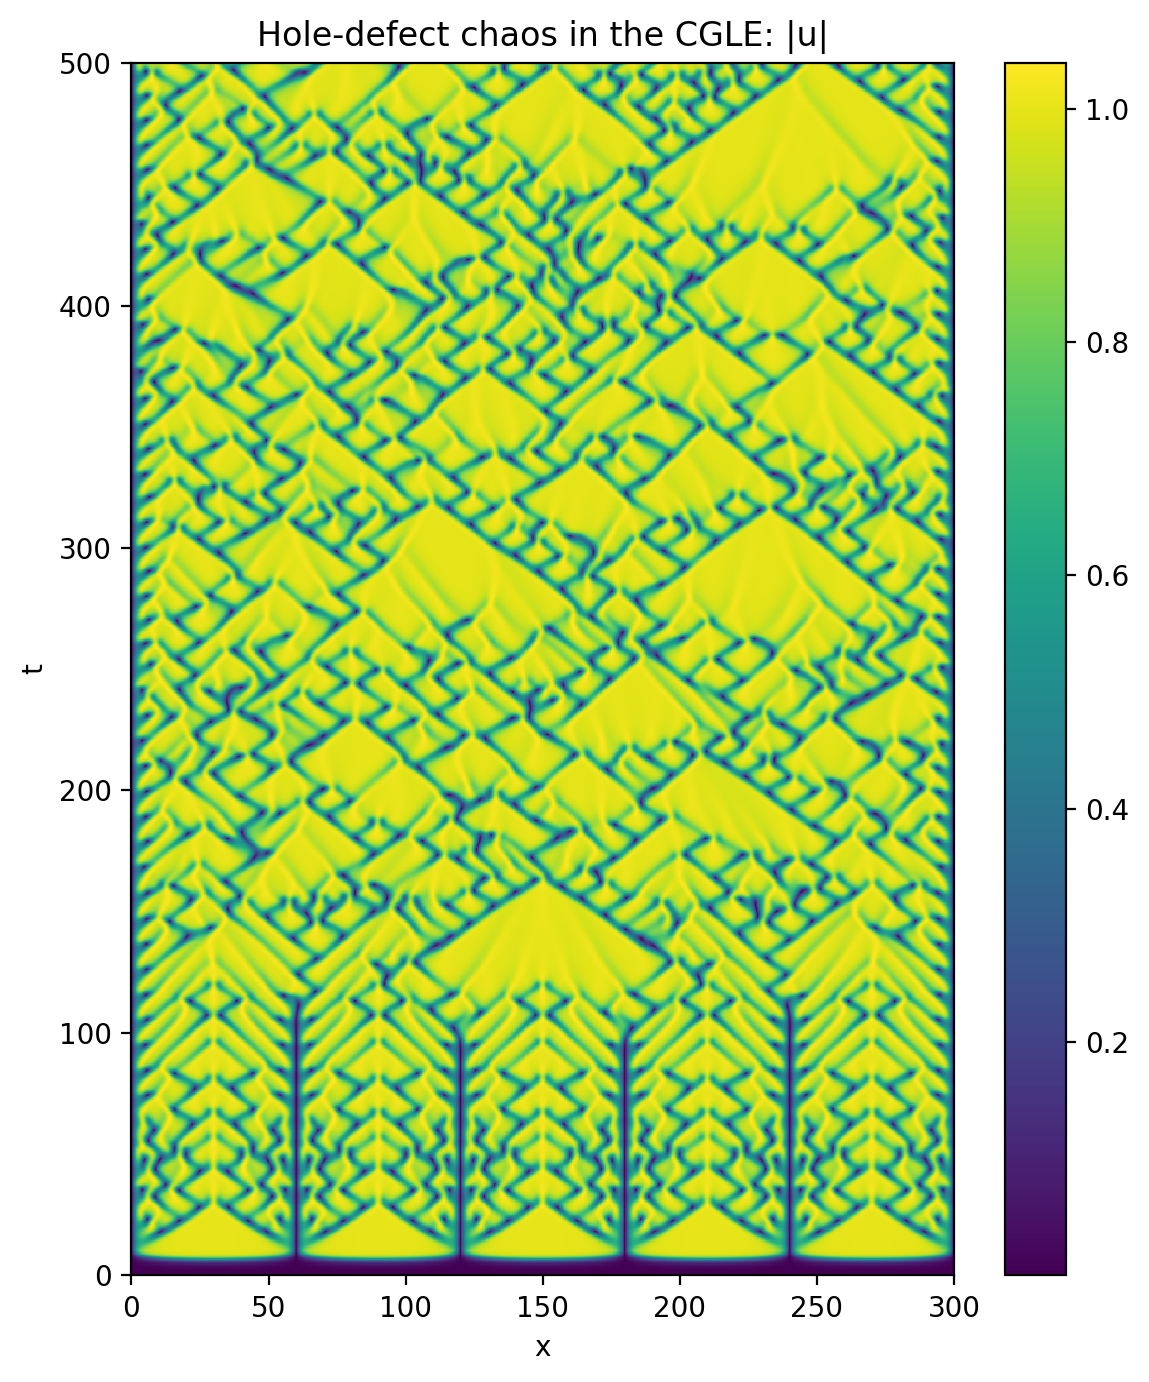

In [54]:
#Plot solution
plt.figure(figsize=(6,7), dpi=100)
plt.pcolormesh(x, t_array, np.abs(u_array), shading='farthest')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Hole-defect chaos in the CGLE: |u|')
plt.tight_layout()

# TUTORIAL 4: Analysing and Post-processing

In [77]:
import h5py
import subprocess

#Clean up old files
import shutil
shutil.rmtree('analyse', ignore_errors=True)

## 4.1 - Analysis

Dedalus includes a framework for evaluating and saving arbitrary analysis tasks whilst an initial value problem is running. Set up the Ginzburg Landau problem once again.

In [78]:
#Basis
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=np.complex128)
xbasis = d3.Chebyshev(xcoord, 1024, bounds=(0, 300), dealias=2)

#Fields
u = dist.Field(name='u', bases=xbasis)
tau1 = dist.Field(name='tau1')
tau2 = dist.Field(name='tau2')

#Subsitutions
dx = lambda A: d3.Differentiate(A, xcoord)
magsq_u = u * np.conj(u)
b = 0.5
c = -1.76

#Tau polynomials
tau_basis = xbasis.derivative_basis(2)
p1 = dist.Field(bases=tau_basis)
p2 = dist.Field(bases=tau_basis)
p1['c'][-1] = 1
p2['c'][-2] = 2

#Problem
problem = d3.IVP([u, tau1, tau2], namespace=locals())
problem.add_equation("dt(u) - u - (1 + 1j*b)*dx(dx(u)) + tau1*p1 + tau2*p2 = - (1 + 1j*c) * magsq_u * u")
problem.add_equation("u(x='left') = 0")
problem.add_equation("u(x='right') = 0")

#Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = 500

#Initial Conditions
x = dist.local_grid(xbasis)
u['g'] = 1e-3 * np.sin(5 * np.pi * x / 360)

2025-05-28 19:19:53,078 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


### Analysis handlers

Explicit evaluation of analysis tasks during timestepping is controlled by solver.evaluator. Various handler objects can be attached to the evaluator, and control when the evaluator computes their own set of tasks and what happens to the resulting data.

E.g. an internal SystemHandler object directs the evaluator to evaluate the RHS expressions on every iteration, and uses the data for the explicit part of the timestepping algorithm.

For simulation analysis, the most useful handler is FileHandler, which regularly computes tasks and writes the data to HDF5 files. When setting up a file handler, specify the name/path for the output directory/files, as well as the cadence at which the handler's task should be evaluated. This can be in terms of any combination of:

- Simulation time, specified with sim_dt
- Wall time, specified with wall_dt
- Iteration number, specified with iter

The output from a file handler is split up into different 'sets' over time, each containing some number of writes that can be limited with the max_writes keyword when the file handler is constructed.

In [79]:
analysis = solver.evaluator.add_file_handler('analysis', iter=10, max_writes=400)

Can add an arbitrary number of file handlers to save different sets of tasks at different cadences and to different files.

### Analysis tasks

Analysis tasks are added to a given handler using the add_task method. Tasks are entered as operator expressions or in plain text and parsed using the same namespace that is used for equation entry. For each task, additionally specify the output layour, scaling factors, and a reference name.

In [80]:
analysis.add_task(d3.Integrate(np.sqrt(magsq_u), 'x')/300, layout='g', name='<|u|>')

For checkpointing, can also simply specify that all the state variables should be saved using the add_tasks method.

In [81]:
analysis.add_tasks(solver.state, layout='g')

Now can run the simulation just as in the previous tutorial, but without needing to manually save any data during the main loop. The evaluator will automatically compute and save the specified analysis tasks at the proper cadence as the simulation is advanced.

In [82]:
#Main loop
timestep = 0.05
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 1000 == 0:
        print('Completed iteration {}'.format(solver.iteration))

Completed iteration 1000
Completed iteration 2000
Completed iteration 3000
Completed iteration 4000
Completed iteration 5000
Completed iteration 6000
Completed iteration 7000
Completed iteration 8000
Completed iteration 9000
Completed iteration 10000
2025-05-28 19:20:01,142 solvers 0/1 INFO :: Simulation stop time reached.


## 4.2 - Post-processing

### File arrangement

By default, the output files for each file handler are arranged as follows:

1. A base folder taking the name that was specified when the file handler was constructed, e.g. analysis/
2. Within the base folder are HDF5 files for each output set, with the same name plus a set number, e.g. analysis_s1.h5
3. When running in parallel, there may also be subfolders for each set containing individual HDF5 files for each process, e.g. analysis_s1/analysis_s1_p0.h5. These process files are "virtually merged" into the corresponding set files, and do not need to be accessed directly. However, the set folders and process files need to be moved/copied along with the set files if data is being relocated

An example with the output files from the previous problem. Three sets should be seen since there are 1000 total outputs with 400 writes per files

In [83]:
print(subprocess.check_output("find analysis | sort", shell=True).decode())

analysis
analysis/analysis_s1.h5
analysis/analysis_s2.h5
analysis/analysis_s3.h5



### Handling data

The HDF5 files produced by Dedalus can be directly accessed using h5py or loaded into xarray.

### Interacting with the files via h5py

Each HDF5 file contains a "task" group containing a dataset for each task assigned to the file handler. The first dimension of the dataset is time, the subsequent dimensions are the vector/tensor components of the task (if applicable), and finally the spatial dimensions of the task.

The HDF5 datasets are self-describing, with dimensional scales for each axis. For the first axis, these include the simulation time, wall time, iteration, and write number. For the spatial axes, the scales correspond to grid points or modes, based on the task layout.

Open up the first analysis set file and plot a time series of the average magnitude:

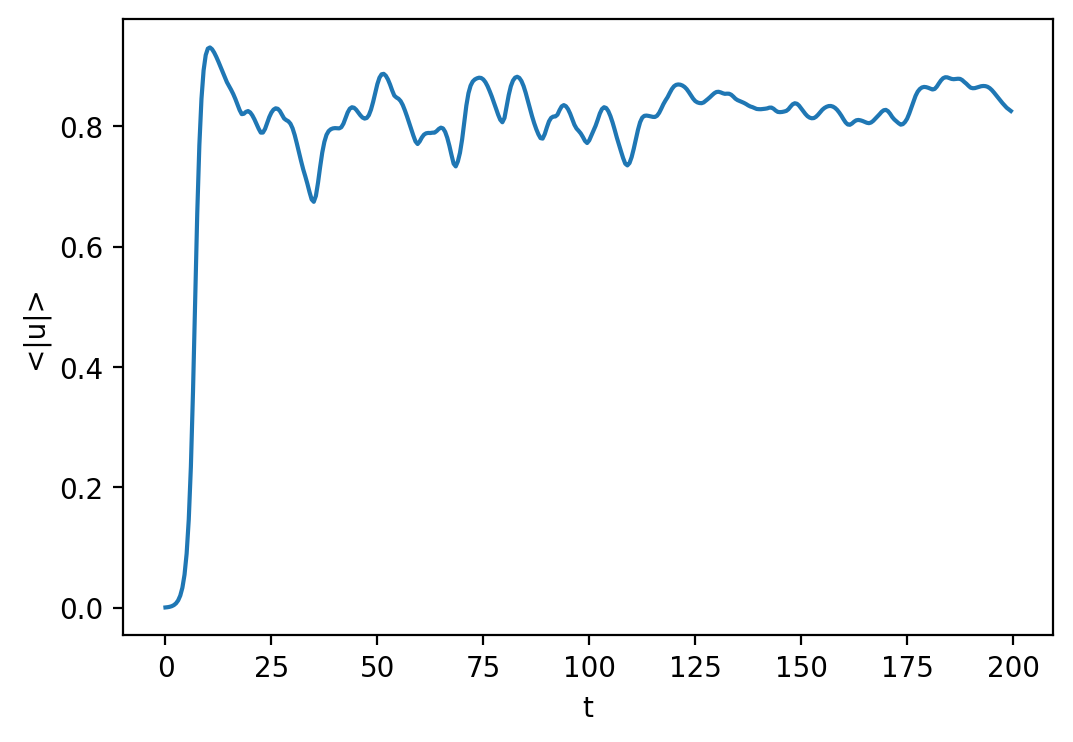

In [84]:
with h5py.File("analysis/analysis_s1.h5", mode='r') as file:
    #Load datasets
    mag_u = file['tasks']['<|u|>']
    t = mag_u.dims[0]['sim_time']
    #Plot data
    fig = plt.figure(figsize=(6,4), dpi=100)
    plt.plot(t[:], mag_u[:].real)
    plt.xlabel('t')
    plt.ylabel('<|u|>')

It is also possible to load analysis tasks directly to the DataArray class provided by xarray, and then use the xarray plotting utilities.

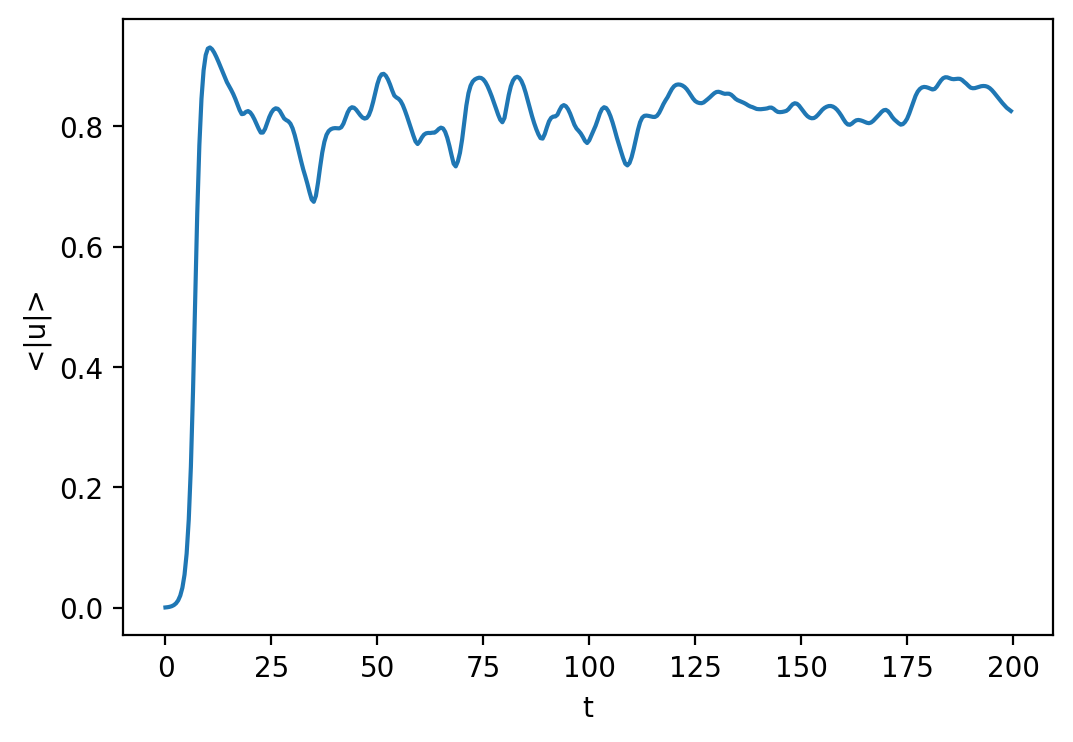

In [85]:
tasks = d3.load_tasks_to_xarray("analysis/analysis_s1.h5")
fig = plt.figure(figsize=(6, 4), dpi=100)
tasks['<|u|>'].real.plot()

Now look at the saved solution over space and time. Plot the phase this time instead of the amplitude.

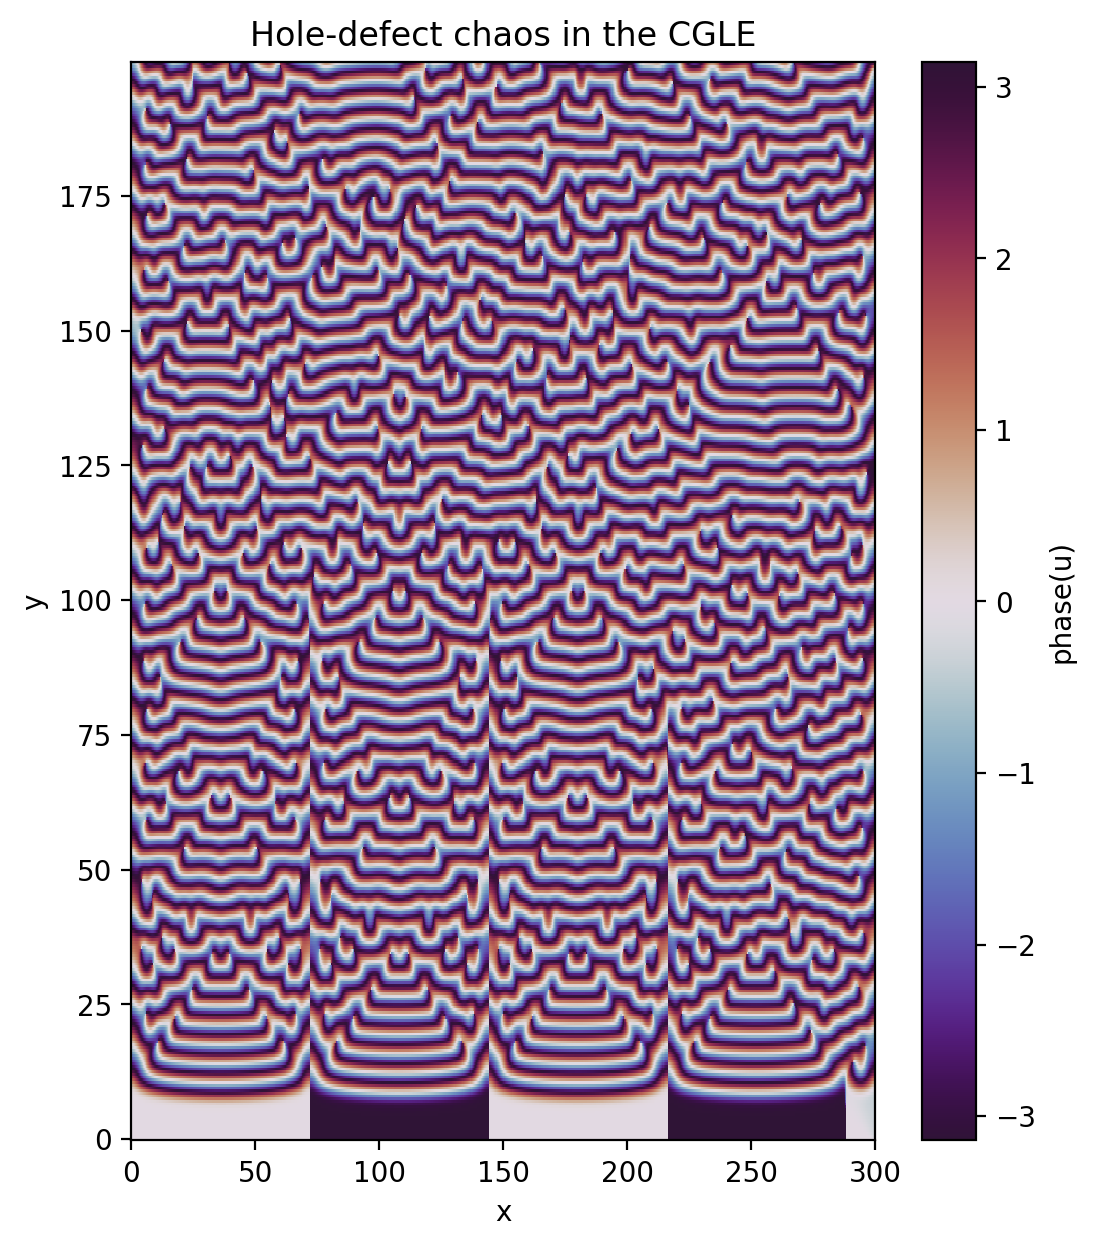

In [86]:
with h5py.File("analysis/analysis_s1.h5", mode='r') as file:
    #Load datasets
    u = file['tasks']['u']
    t = u.dims[0]['sim_time']
    x = u.dims[1][0]
    #Plot data
    u_phase = np.arctan2(u[:].imag, u[:].real)
    plt.figure(figsize=(6, 7), dpi=100)
    plt.pcolormesh(x[:], t[:], u_phase, shading='nearest', cmap='twilight_shifted')
    plt.colorbar(label='phase(u)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Hole-defect chaos in the CGLE')

Can also be simplified by loading and plotting the data via xarray:

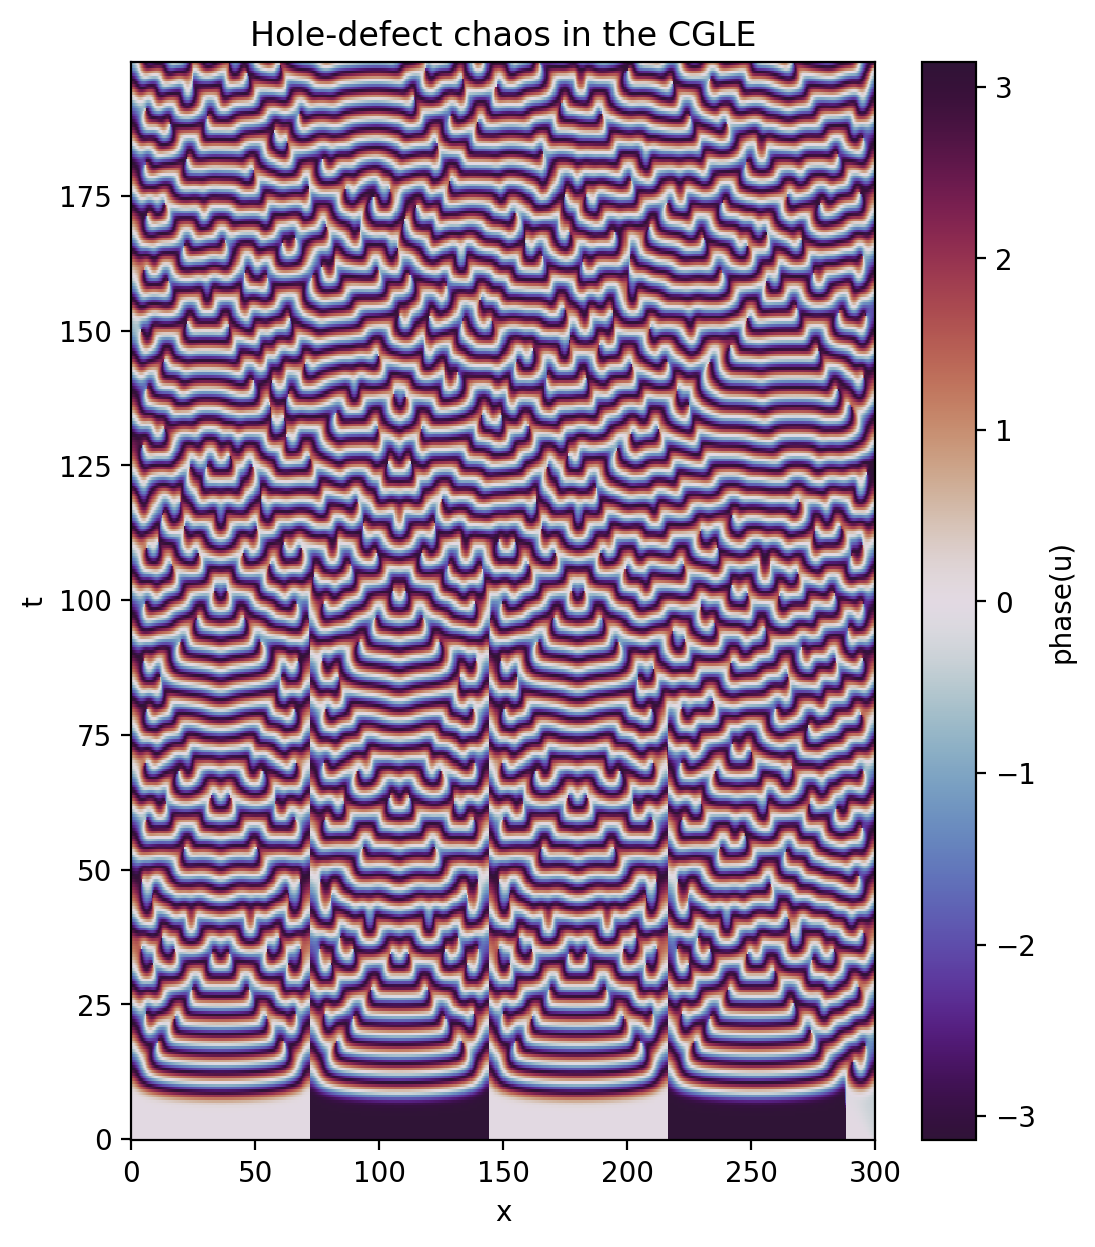

In [87]:
tasks = d3.load_tasks_to_xarray("analysis/analysis_s1.h5")
u_phase = np.arctan2(tasks['u'].imag, tasks['u'].real)
u_phase.name = "phase(u)"

plt.figure(figsize=(6,7), dpi=100)
u_phase.plot(x='x', y='t', cmap='twilight_shifted')
plt.title('Hole-defect chaos in the CGLE');